In [2]:
import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import offline
import plotly.plotly as py
import plotly.graph_objs as go
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Read data

In [76]:
application_train = pd.read_csv("../input/application_train.csv") 
application_test = pd.read_csv("../input/application_test.csv")

In [4]:
print('Training data shape: ', application_train.shape)
application_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print('Test data shape: ', application_test.shape)
application_test.head()

Test data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
application_train.get_dtype_counts() # same as:
#application_train.dtypes.value_counts() 

float64    65
int64      41
object     16
dtype: int64

In [28]:
application_train.dtypes.head()

SK_ID_CURR             int64
TARGET                 int64
NAME_CONTRACT_TYPE    object
CODE_GENDER           object
FLAG_OWN_CAR          object
dtype: object

# Exploratory Data Analysis
### Target Variable

In [10]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

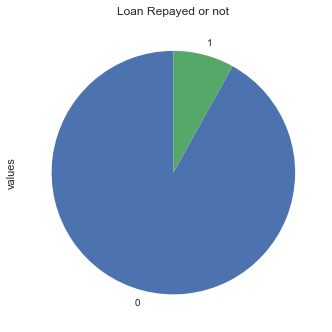

In [13]:
plt.figure(figsize=(12,6))
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
ax1 = plt.subplot(121, aspect='equal')
df.plot(kind='pie', y='values', ax=ax1, startangle=90, legend = False, title='Loan Repayed or not');

This is an imbalanced class problem. 0 represents loan being repaid and 1 represents loan not being repaid. We might need resampling methods or adjusting the weights in machine learning modeling.

As there are so many variables, we would not go through each one. So let's look at correlation coefficient between each numerical variable and the target.
## Numerical Variables

In [77]:
%%time
numerics = ['int64','float64']
correlations = application_train.select_dtypes(include=numerics).corr()['TARGET'].\
                map(abs).sort_values(ascending=False)

# Display correlations
print('Most correlated variables:\n', correlations.head(15))
print('\nLess correlated variables:\n', correlations.tail(15))

Most correlated variables:
 TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                  0.044003
Name: TARGET, dtype: float64

Less correlated variables:
 FLAG_DOCUMENT_4               0.002672
SK_ID_CURR                    0.002108
AMT_REQ_CREDIT_BUREAU_QRT     0.002022
FLAG_EMAIL                    0.001758
NONLIVINGAPARTMENTS_MODE      0.001557
FLAG_DOCUMENT_7               0.001520
FLAG_DOCUMENT_10              0.001414
FLAG_DOCUMENT_19              0.001358
AM

With tree-based models, we can safely ignore correlation issues. But let's look at standard deviation

### Draw distribution of a few variables

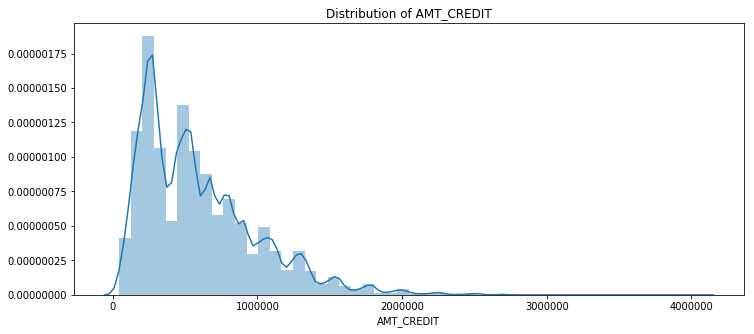

In [50]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(application_train["AMT_CREDIT"])

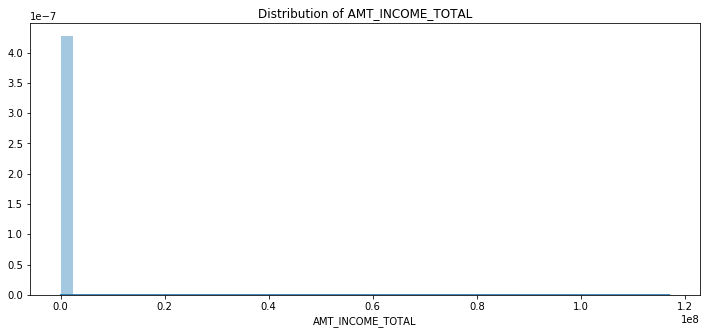

In [52]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_INCOME_TOTAL")
ax = sns.distplot(application_train["AMT_INCOME_TOTAL"])

In [38]:
application_train["AMT_INCOME_TOTAL"].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

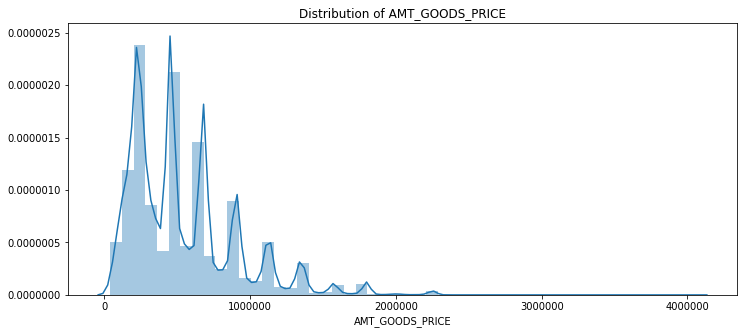

In [55]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(application_train["AMT_GOODS_PRICE"].dropna())

DAYS_BIRTH is negative

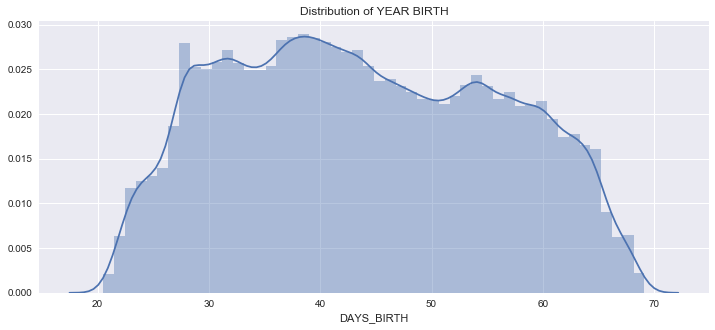

In [41]:
plt.figure(figsize=(12,5))
plt.title("Distribution of YEAR BIRTH")
ax = sns.distplot(application_train['DAYS_BIRTH'] / -365)

### Anomalies

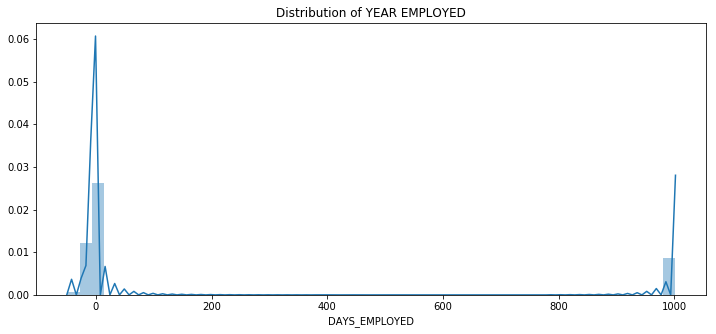

In [4]:
plt.figure(figsize=(12,5))
plt.title("Distribution of YEAR EMPLOYED")
ax = sns.distplot(application_train['DAYS_EMPLOYED']/365)

That doesn't make sense. Some people were employed 1000 years! And the bin near 1000 years is on the positive side while rest of the data is on negative side.

In [39]:
max(application_train['DAYS_EMPLOYED'])

365243

In [5]:
application_train[application_train['DAYS_EMPLOYED'] != 365243]['DAYS_EMPLOYED'].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [47]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


The anomalies have a lower rate of default. We will replace the anomaly values with na and create a new column flagging the anomalies

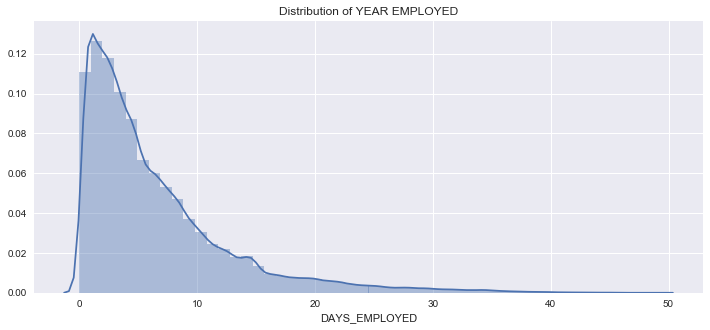

In [48]:
plt.figure(figsize=(12,5))
plt.title("Distribution of YEAR EMPLOYED")
ax = sns.distplot(non_anom['DAYS_EMPLOYED'].dropna()/-365)

In [42]:
# test set has the outlier as well
max(application_test['DAYS_EMPLOYED'])

365243

EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, and DAYS_BIRTH have strongest relationship with the target.

### Draw distribution separating by TARGET

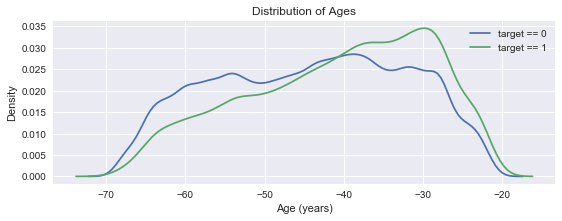

In [16]:
plt.figure(figsize = (9, 3))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Loans not repaid line skewed towards younger age than loans repaid

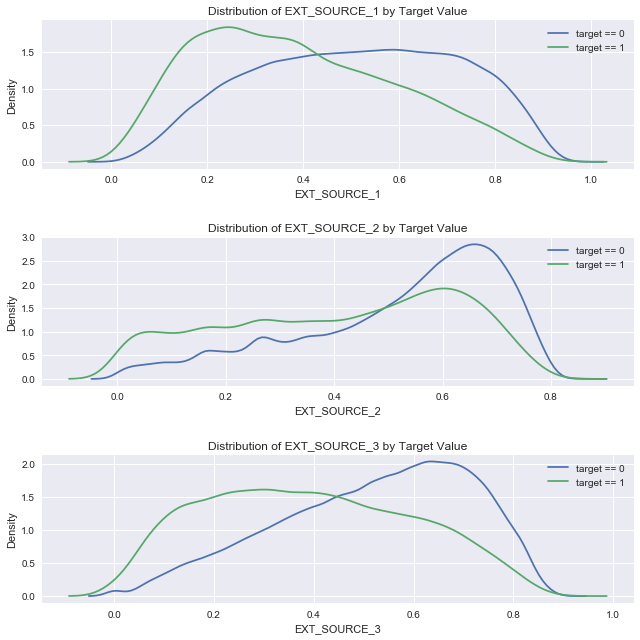

In [17]:
plt.figure(figsize = (9, 9))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### Examine missing value

In [91]:
def missing_value_table(df):
    # number of missing values
    na_totals = df.isnull().sum()
    # percentage of missing values
    na_percent = 100 * df.isnull().sum() / len(df)
    # create a table
    na_table = pd.concat([na_totals, na_percent], axis=1)
    
    na_table_rename = na_table.rename(
        columns = {0 : '# of Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    na_table_rename = na_table_rename[
        na_table_rename.iloc[:,1] != 0].sort_values(by=['% of Total Values'],ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(na_table_rename.shape[0]) +
           " columns that have missing values.")
    return na_table_rename

In [92]:
missing_value_table(application_train).head(10)

Your selected dataframe has 241 columns.
There are 62 columns that have missing values.


,# of Missing Values,% of Total Values
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
FLOORSMIN_MODE,208642,67.8


## Check standard deviation
We want to remove columns where values remained unchanged, so variance would be a good statistic to check. But first, deal with anomalies and missing value. In addition, let's combine train and test data to look together.

In [36]:
df = application_train.append(application_test).reset_index(drop=True)

# Create an anomalous flag column
df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [60]:
# Median imputation of missing values
float_col = df.select_dtypes(include='float64').drop(['TARGET'],axis=1)
imputer = Imputer(strategy = 'median')
float_df = pd.DataFrame(data=imputer.fit_transform(float_col),    # values
                              columns=float_col.columns)

In [53]:
float_df.shape

(356255, 66)

In [97]:
stds = float_df.std(axis=0).sort_values(ascending = True)
stds.head()

REGION_POPULATION_RELATIVE     0.013915
NONLIVINGAPARTMENTS_MODE       0.025945
NONLIVINGAPARTMENTS_MEDI       0.026636
NONLIVINGAPARTMENTS_AVG        0.026843
YEARS_BEGINEXPLUATATION_AVG    0.041604
dtype: float64

In [91]:
# top 14 features that are most related to TARGET

df[correlations.index[:15].tolist()].std(axis=0)

TARGET                            0.272419
EXT_SOURCE_3                      0.194141
EXT_SOURCE_2                      0.189753
EXT_SOURCE_1                      0.210045
DAYS_BIRTH                     4358.803980
REGION_RATING_CLIENT_W_CITY       0.504586
REGION_RATING_CLIENT              0.510947
DAYS_LAST_PHONE_CHANGE          835.063902
DAYS_ID_PUBLISH                1517.901735
REG_CITY_NOT_WORK_CITY            0.420616
FLAG_EMP_PHONE                    0.385434
DAYS_EMPLOYED                  2334.479967
REG_CITY_NOT_LIVE_CITY            0.268292
FLAG_DOCUMENT_3                   0.448752
FLOORSMAX_AVG                     0.145051
dtype: float64

In [89]:
VarianceThreshold(.01).fit_transform(float_df).shape 

(356255, 25)

In [96]:
# This is a list of columns which have variance lower than 0.01
stds.head(41).index.tolist()

['REGION_POPULATION_RELATIVE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'COMMONAREA_MODE',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAREA_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MODE',
 'BASEMENTAREA_MEDI',
 'LANDAREA_MEDI',
 'BASEMENTAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'BASEMENTAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_AVG',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'APARTMENTS_MODE',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'TOTALAREA_MODE',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MODE',
 'LIVINGAREA_MEDI',
 'FLOORSMIN_MODE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'ELEVATORS_MODE']

## Columns of Object type
Compared with missing value table, it seems that only numerical columns have missing values

In [35]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Percentage of default by a few categorical columns

Text(0.5,1,'Percentage of default by NAME_CONTRACT_TYPE')

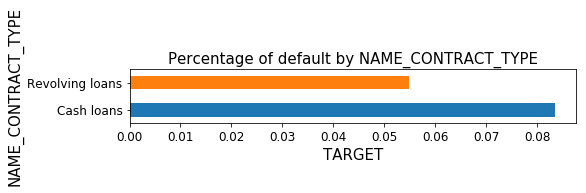

In [11]:
default_by_NAME_CONTRACT_TYPE  = application_train.groupby(['NAME_CONTRACT_TYPE'])['TARGET'].mean().plot('barh',figsize = (8,1),fontsize = 12)
plt.xlabel('TARGET',fontsize = 15)
plt.ylabel('NAME_CONTRACT_TYPE',fontsize = 15)
plt.title('Percentage of default by NAME_CONTRACT_TYPE', fontsize = 15)

Text(0.5,1,'Percentage of default by CODE_GENDER')

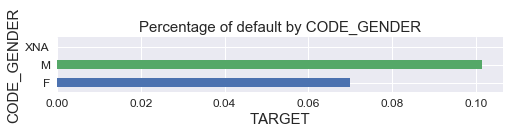

In [49]:
default_by_NAME_CONTRACT_TYPE  = application_train.groupby(['CODE_GENDER'])['TARGET'].mean().plot('barh',figsize = (8,1),fontsize = 12)
plt.xlabel('TARGET',fontsize = 15)
plt.ylabel('CODE_GENDER',fontsize = 15)
plt.title('Percentage of default by CODE_GENDER', fontsize = 15)

In [50]:
application_train['CODE_GENDER'].value_counts() 

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Since there is only 4 XNA gender, we can delete it from the CODE_GENDER

Text(0.5,1,'Percentage of default by FLAG_OWN_REALTY')

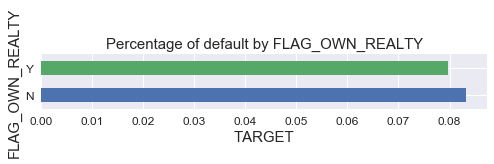

In [51]:
default_by_NAME_CONTRACT_TYPE  = application_train.groupby(['FLAG_OWN_REALTY'])['TARGET'].mean().plot('barh',figsize = (8,1),fontsize = 12)
plt.xlabel('TARGET',fontsize = 15)
plt.ylabel('FLAG_OWN_REALTY',fontsize = 15)
plt.title('Percentage of default by FLAG_OWN_REALTY', fontsize = 15)

Text(0.5,1,'Percentage of default by NAME_INCOME_TYPE')

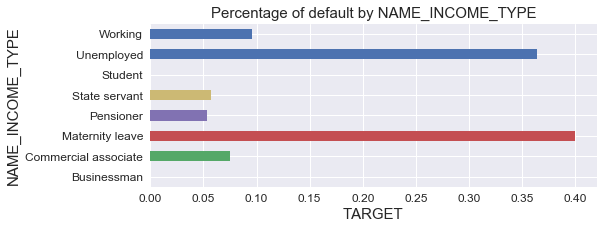

In [52]:
default_by_NAME_CONTRACT_TYPE  = application_train.groupby(['NAME_INCOME_TYPE'])['TARGET'].mean().plot('barh',figsize = (8,3),fontsize = 12)
plt.xlabel('TARGET',fontsize = 15)
plt.ylabel('NAME_INCOME_TYPE',fontsize = 15)
plt.title('Percentage of default by NAME_INCOME_TYPE', fontsize = 15)

Text(0.5,1,'Percentage of default by OCCUPATION_TYPE')

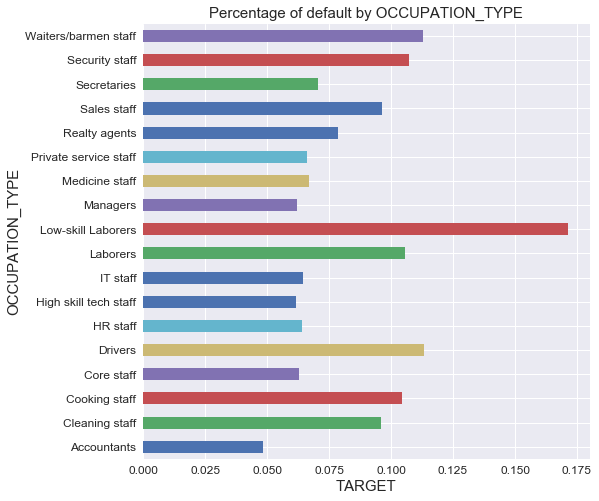

In [53]:
default_by_NAME_CONTRACT_TYPE  = application_train.groupby(['OCCUPATION_TYPE'])['TARGET'].mean().plot('barh',figsize = (8,8),fontsize = 12)
plt.xlabel('TARGET',fontsize = 15)
plt.ylabel('OCCUPATION_TYPE',fontsize = 15)
plt.title('Percentage of default by OCCUPATION_TYPE', fontsize = 15)